Basic Usage, ZebraFish Haemoglobin protein
======================


## ``Gromacs_py`` basic example

Here is an example of a short simulation of the Zebrafish Haemoglobin protein.

Five successive steps are used:

1. Topology creation using ``GmxSys.add_top()``.
2. Solvation of the system using ``GmxSys.solvate_add_ions()``.
3. Minimisation of the structure using ``GmxSys.em_2_steps()``.
4. Equilibration of the system using ``GmxSys.em_equi_three_step_iter_error()``.
5. Production run using ``GmxSys.production()``.

### Import

In [77]:
import sys
import os
import shutil

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## To use `gromacs_py` in a project

In [2]:
from gromacs_py import gmx

## Simulation setup

- Define a few variables for you simulation, like:
  
    1. simulation output folders
    2. ionic concentration
    3. number of minimisation steps
    4. equilibration and production time

### Regarding equilibriation time:
The following variables define the sim times (relative units) for each stage of the three-stage equilibriation process. Check notes below for details:

1. `HA_time`
2. `CA_time`
3. `CA_LOW_time` 


In [3]:
DATA_OUT = 'zeb_hb_only_sim'

# System Setup
vsite='none'
sys_top_folder = os.path.join(DATA_OUT, 'sys_top')
ignore_hydrogen = {'ignh': None}

# Energy Minimisation
em_folder = os.path.join(DATA_OUT, 'em')
em_sys_folder = os.path.join(DATA_OUT, 'sys_em')
em_step_number = 10000
emtol = 10.0  	# Stop minimization when the maximum force < 10 J/mol
emstep  = 0.01      # Energy step size


# Equillibration
equi_folder = os.path.join(DATA_OUT, 'sys_equi')
HA_time = 0.5
CA_time = 1.0
CA_LOW_time = 2.0

dt_HA = 0.001
dt = 0.002

HA_step = 1000 * HA_time / dt_HA
CA_step = 1000 * CA_time / dt
CA_LOW_step = 1000 * CA_LOW_time / dt

# Production
os.makedirs(DATA_OUT, exist_ok = True)
prod_folder = os.path.join(DATA_OUT, 'sys_prod')
prod_time = 10.0

prod_step = 1000 * prod_time / dt

## Create the `GmxSys` object

Load PDB file on disk

In [4]:
pdb_file = "pdbs/ZEB_HB_Refined.pdb"
sys_name = "zeb_hb"
md_sys = gmx.GmxSys(name=sys_name, coor_file=pdb_file)

## Create topology:

**Note:** Hydrogen atoms need to be ignored, or else this won't work with this particular pdb

Topology creation involves:
- topology creation using `pdb2gmx` via the `add_top()` function
  * The easier `prepare_top()` function won't work here, 
  * as there seems to be a problem with the hydrogen information in the PDB, 
  * necessitating the passing of `-ign` option to `pdb2gmx` which `prepare_top()` can't do.
- box creation using `editconf`
- Supposed to use AMBER force-field so that `acpype` can be used to prepare ligand topologies automatically when needed: [See this doc](https://gromacs-py.readthedocs.io/en/latest/notebook/01_dna_ligand_ambertools.html). The example in the doc requires the `prepare_top()` function, which fails for this protein. So we should use the `prepare_top_ligand()` and `insert_mol_sys()` methods in `gromacs_py` ([see this doc](https://github.com/samuelmurail/gromacs_py/blob/master/gromacs_py/gmx/gmxsys.py#L1529C9-L1529C27) and [this example](https://github.com/samuelmurail/gromacs_py/blob/master/gromacs_py/gmx/gmxsys.py#L210)) which also seems to use `acpype` through `ambertools`.
- Alternatively, use charmm with manual addition of ligand topology using [CGenFF Script](https://github.com/Lemkul-Lab/cgenff_charmm2gmx)



In [5]:
md_sys.add_top(out_folder=DATA_OUT, name=sys_name, pdb2gmx_option_dict=ignore_hydrogen, ff="amber99sb-ildn")
md_sys.create_box(dist=1.0, box_type="dodecahedron", check_file_out=True)

gmx pdb2gmx -f ../ZEB_HB_Refined.pdb -o zeb_hb_pdb2gmx.pdb -p zeb_hb_pdb2gmx.top -i zeb_hb_posre.itp -water tip3p -ff amber99sb-ildn -ignh
gmx editconf -f zeb_hb_only_sim/zeb_hb_pdb2gmx.pdb -o zeb_hb_only_sim/zeb_hb_pdb2gmx_box.pdb -bt dodecahedron -d 1.0


## Solvation (water and $Na^{+} Cl^{-}$)

In [6]:
#solvate and add ions
md_sys.solvate_add_ions(out_folder=DATA_OUT, name=sys_name,create_box_flag=False)

gmx grompp -f ../../../../../../usr/local/condaenv/envs/mdanalysis-old/lib/python3.12/site-packages/gromacs_py/gmx/template/mini.mdp -c zeb_hb_water.pdb -r zeb_hb_water.pdb -p zeb_hb_water_ion.top -po out_mini.mdp -o genion_zeb_hb_water_ion.tpr -maxwarn 1
gmx genion -s genion_zeb_hb_water_ion.tpr -p zeb_hb_water_ion.top -o zeb_hb_water_ion.gro -np 17 -pname NA -nn 18 -nname CL


## Energy minimisation

Set parallelization and GPU options here. Change them later, if needed.

In [7]:
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '16'))

#Set Parallelization
md_sys.nt = nthreads
#md_sys.ntmpi = 1
md_sys.gpu_id = '0'

md_sys.em_2_steps(out_folder=em_folder,
        no_constr_nsteps=em_step_number,
        constr_nsteps=em_step_number,
        posres="",
        create_box_flag=False, emtol=emtol, emstep=emstep)

WARNING !!! ADDING unusual parameter : "emtol"in the mdp file Init_em_zeb_hb.mdp
WARNING !!! ADDING unusual parameter : "emstep"in the mdp file Init_em_zeb_hb.mdp


gmx grompp -f Init_em_zeb_hb.mdp -c ../zeb_hb_water_ion.gro -r ../zeb_hb_water_ion.gro -p ../zeb_hb_water_ion.top -po out_Init_em_zeb_hb.mdp -o Init_em_zeb_hb.tpr -maxwarn 1
gmx mdrun -s Init_em_zeb_hb.tpr -deffnm Init_em_zeb_hb -nt 16 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/10000 [00:00<?, ?it/s]

WARNING !!! ADDING unusual parameter : "emtol"in the mdp file zeb_hb.mdp
WARNING !!! ADDING unusual parameter : "emstep"in the mdp file zeb_hb.mdp


gmx grompp -f zeb_hb.mdp -c Init_em_zeb_hb.gro -r Init_em_zeb_hb.gro -p ../zeb_hb_water_ion.top -po out_zeb_hb.mdp -o zeb_hb.tpr -maxwarn 1
gmx mdrun -s zeb_hb.tpr -deffnm zeb_hb -nt 16 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/10000 [00:00<?, ?it/s]

## Plot energy:

In [8]:
ener_pd_1 = md_sys.sys_history[-1].get_ener(selection_list=['Potential'])
ener_pd_2 = md_sys.get_ener(selection_list=['Potential'])

ener_pd_1['label'] = 'no bond constr'
ener_pd_2['label'] = 'bond constr'

ener_pd = pd.concat([ener_pd_1, ener_pd_2])

ener_pd['Time (ps)'] = np.arange(len(ener_pd))

gmx energy -f zeb_hb_only_sim/em/Init_em_zeb_hb.edr -o tmp_edr.xvg
gmx energy -f zeb_hb_only_sim/em/zeb_hb.edr -o tmp_edr.xvg


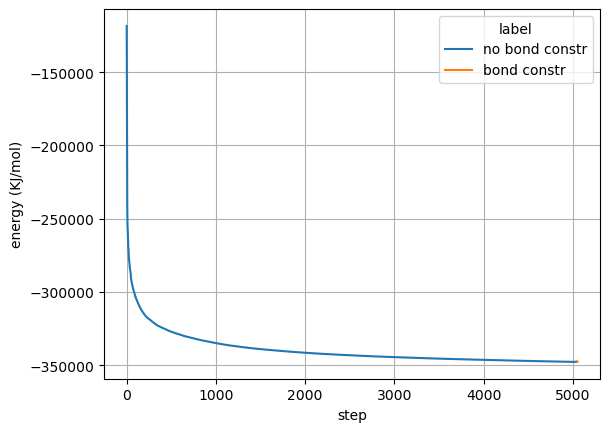

In [9]:
ax = sns.lineplot(x="Time (ps)", y="Potential",
        hue="label",
        data=ener_pd)
ax.set_xlabel('step')
ax.set_ylabel('energy (KJ/mol)')
plt.grid()

## System minimisation and equilibration

Based on `gromacs_py` docs, this is a 3-stage equilibriation process. 

All three steps seem to be NPT with berendsen coupling and v-rescale for temp coupling. Each step just has different restraints. This does not seem so bad: closer to lab conditions.

Since the statistical ensemble is pretty much always NPT, this is different from the Lemkul-lysozyme tutorial at [MDTutorials](http://www.mdtutorials.com/gmx/lysozyme/).

**Note:** Had to run this on param at least. Too slow even in ofc workstn.

In [10]:
md_sys.em_equi_three_step_iter_error(out_folder=equi_folder,
    no_constr_nsteps=em_step_number,
    constr_nsteps=em_step_number,
    nsteps_HA=HA_step,  
    nsteps_CA=CA_step,
    nsteps_CA_LOW=CA_LOW_step,
    dt=dt, dt_HA=dt_HA,
    vsite=vsite, maxwarn=1)


gmx grompp -f Init_em_zeb_hb.mdp -c ../../em/zeb_hb.gro -r ../../em/zeb_hb.gro -p ../../zeb_hb_water_ion.top -po out_Init_em_zeb_hb.mdp -o Init_em_zeb_hb.tpr -maxwarn 1
gmx mdrun -s Init_em_zeb_hb.tpr -deffnm Init_em_zeb_hb -nt 16 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/10000 [00:00<?, ?it/s]

gmx grompp -f zeb_hb.mdp -c Init_em_zeb_hb.gro -r Init_em_zeb_hb.gro -p ../../zeb_hb_water_ion.top -po out_zeb_hb.mdp -o zeb_hb.tpr -maxwarn 1
gmx mdrun -s zeb_hb.tpr -deffnm zeb_hb -nt 16 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/10000 [00:00<?, ?it/s]

gmx trjconv -f zeb_hb_only_sim/sys_equi/sys_em/zeb_hb.gro -o zeb_hb_only_sim/sys_equi/sys_em/zeb_hb_compact.pdb -s zeb_hb_only_sim/sys_equi/sys_em/zeb_hb.tpr -ur compact -pbc mol
gmx grompp -f equi_HA_zeb_hb.mdp -c ../../sys_em/zeb_hb_compact.pdb -r ../../sys_em/zeb_hb_compact.pdb -p ../../../zeb_hb_water_ion.top -po out_equi_HA_zeb_hb.mdp -o equi_HA_zeb_hb.tpr -maxwarn 1
gmx mdrun -s equi_HA_zeb_hb.tpr -deffnm equi_HA_zeb_hb -nt 16 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/500000 [00:00<?, ?it/s]

gmx grompp -f equi_CA_zeb_hb.mdp -c ../00_equi_HA/equi_HA_zeb_hb.gro -r ../../sys_em/zeb_hb_compact.pdb -p ../../../zeb_hb_water_ion.top -po out_equi_CA_zeb_hb.mdp -o equi_CA_zeb_hb.tpr -maxwarn 1
gmx mdrun -s equi_CA_zeb_hb.tpr -deffnm equi_CA_zeb_hb -nt 16 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/500000 [00:00<?, ?it/s]

gmx grompp -f equi_CA_LOW_zeb_hb.mdp -c ../01_equi_CA/equi_CA_zeb_hb.gro -r ../../sys_em/zeb_hb_compact.pdb -p ../../../zeb_hb_water_ion.top -po out_equi_CA_LOW_zeb_hb.mdp -o equi_CA_LOW_zeb_hb.tpr -maxwarn 1
gmx mdrun -s equi_CA_LOW_zeb_hb.tpr -deffnm equi_CA_LOW_zeb_hb -nt 16 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/1000000 [00:00<?, ?it/s]

### Plot Equilibriation

Since the statistical ensemble is pretty much always NPT, this is different from the Lemkul-lysozyme tutorial at [MDTutorials](http://www.mdtutorials.com/gmx/lysozyme/). So we need to see Volume as well as Pressure, temperature, and density.

In [113]:
quantities = ["Temperature", "Pressure", "Volume", "Density"]
units = ["$K$", "$bar$", "$A^3$", "$kg/m^3$"]

pd_1 = md_sys.sys_history[-2].get_ener(selection_list=quantities)
pd_2 = md_sys.sys_history[-1].get_ener(selection_list=quantities)
pd_3 = md_sys.get_ener(selection_list=quantities)

pd_1['label'] = 'HA_constr'
pd_2['label'] = 'CA_constr'
pd_2['Time (ps)'] = pd_2['Time (ps)'] + pd_1['Time (ps)'].max()
pd_3['label'] = 'CA_LOW_constr'
pd_3['Time (ps)'] = pd_3['Time (ps)'] + pd_2['Time (ps)'].max()

display(pd.concat([pd_1, pd_2, pd_3]))

gmx energy -f zeb_hb_only_sim/sys_equi/sys_equi/00_equi_HA/equi_HA_zeb_hb.edr -o tmp_edr.xvg
gmx energy -f zeb_hb_only_sim/sys_equi/sys_equi/01_equi_CA/equi_CA_zeb_hb.edr -o tmp_edr.xvg
gmx energy -f zeb_hb_only_sim/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_zeb_hb.edr -o tmp_edr.xvg


,Time (ps),Temperature,Pressure,Volume,Density,label
0,0.0,0.036960,-3212.161865,220.624832,997.830444,HA_constr
1,5.0,297.365814,-375.628571,217.554230,1011.914001,HA_constr
2,10.0,304.742004,261.917603,216.690277,1015.948547,HA_constr
3,15.0,298.997650,138.516022,216.272339,1017.911865,HA_constr
4,20.0,302.173218,415.378693,215.817825,1020.055542,HA_constr
...,...,...,...,...,...,...
196,3460.0,299.907013,-201.050339,215.239182,1022.797852,CA_LOW_constr
197,3470.0,300.963898,-253.437943,214.624390,1025.727661,CA_LOW_constr
198,3480.0,301.291687,-168.079300,217.620911,1011.603943,CA_LOW_constr
199,3490.0,297.199707,-405.602264,218.009903,1009.798950,CA_LOW_constr


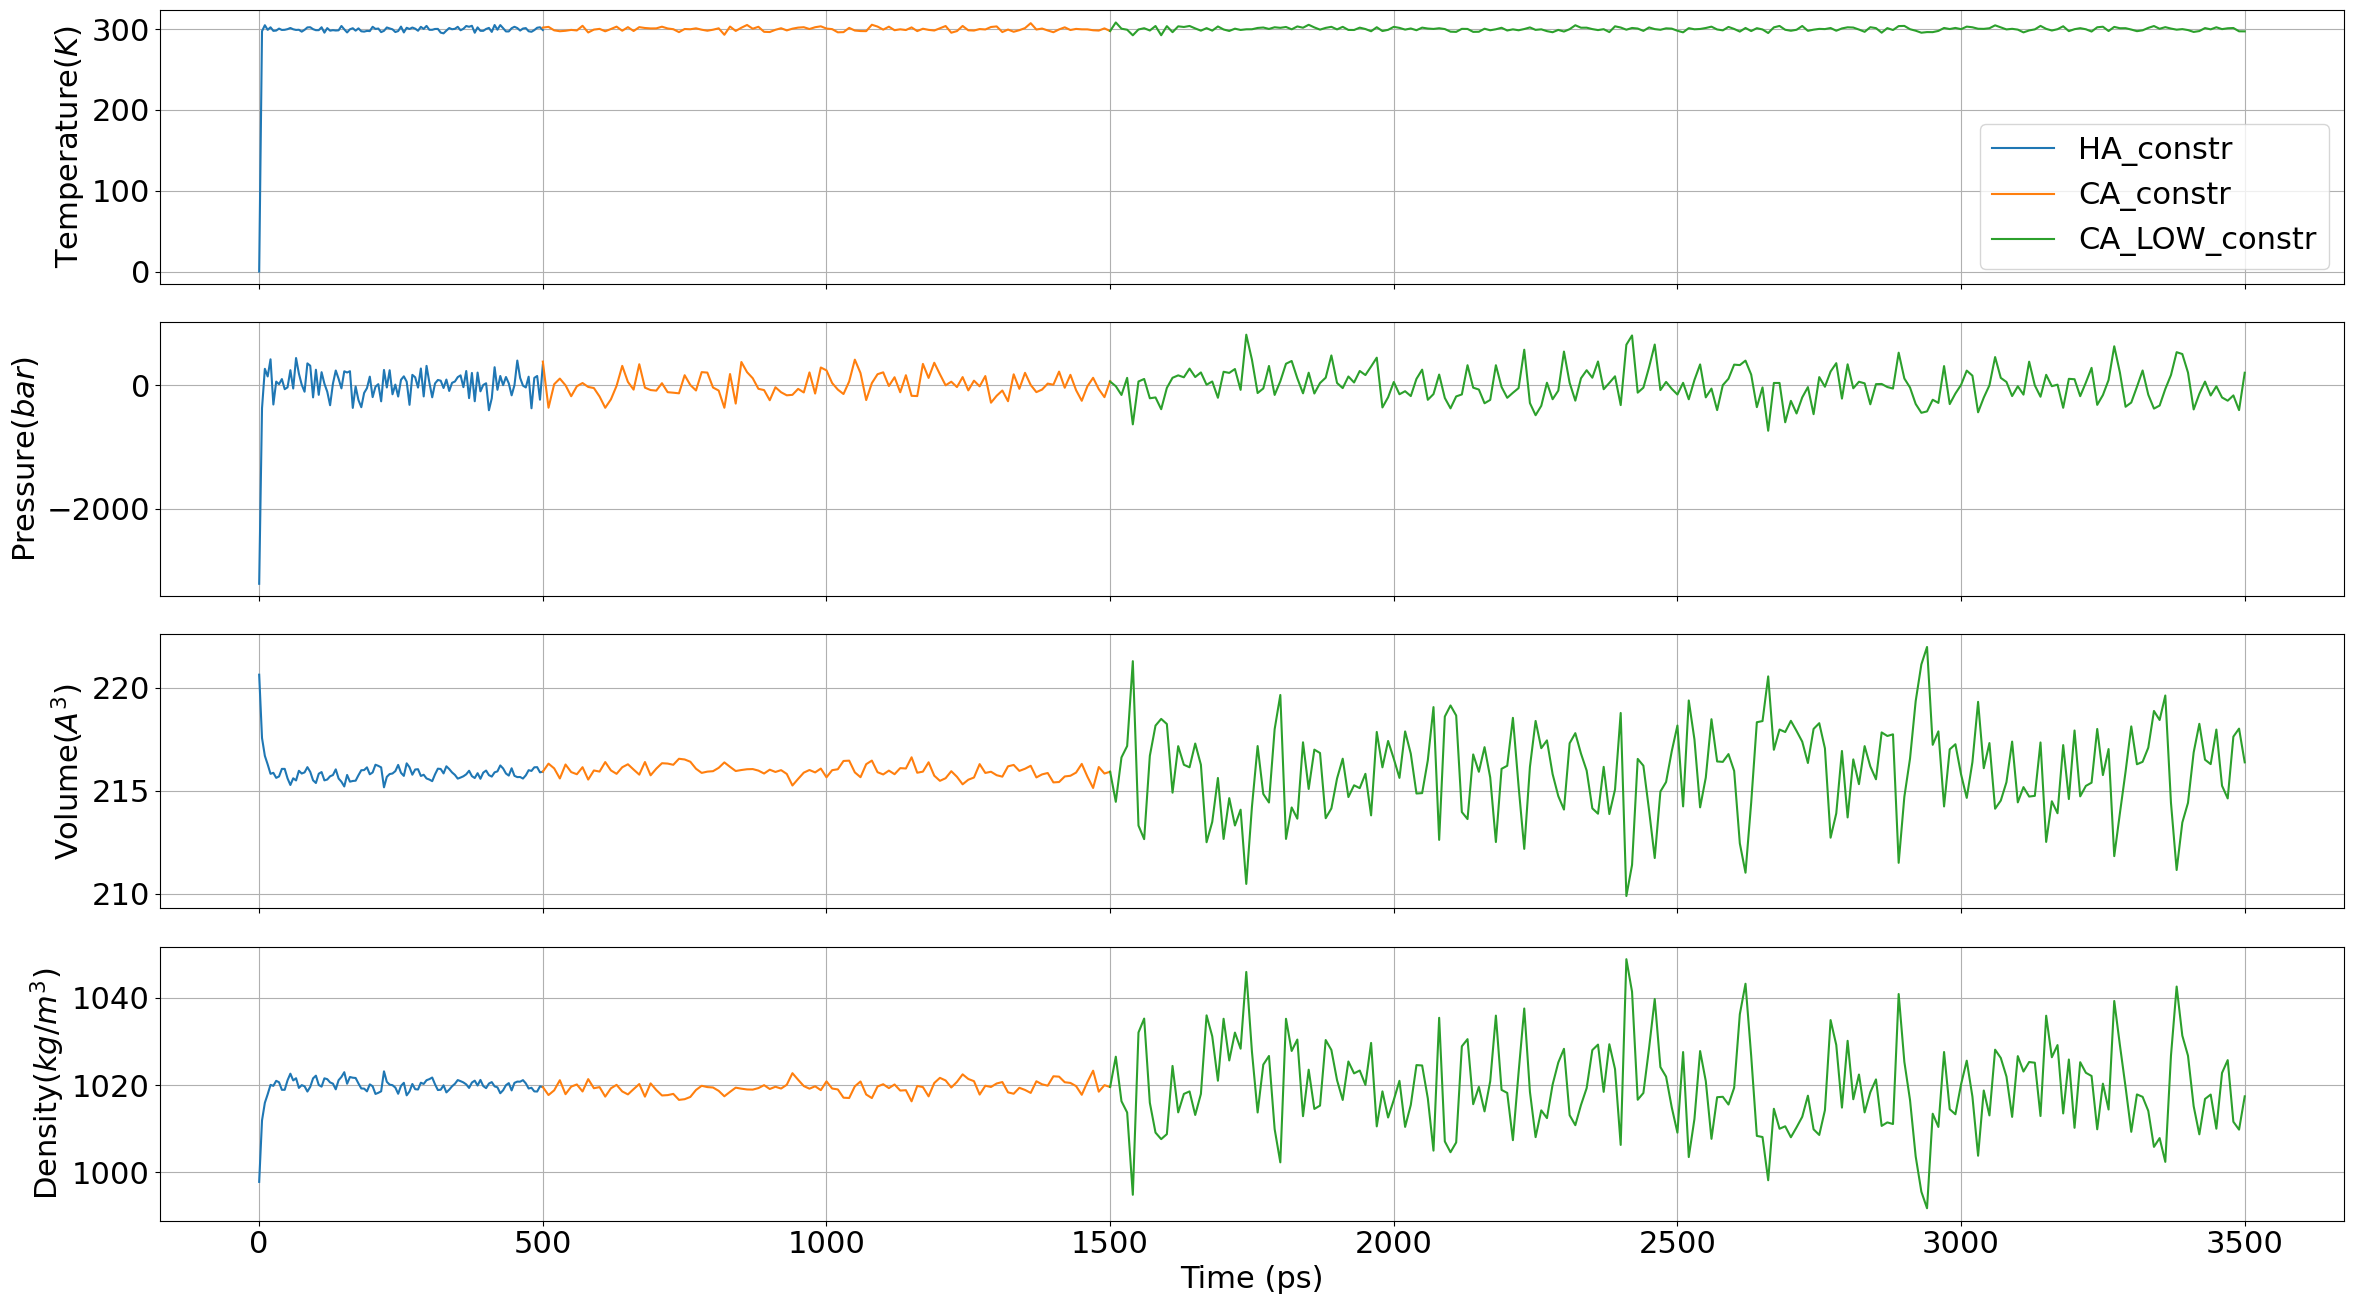

In [112]:
plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(4, 1, figsize=(24,13.5), sharex=True, tight_layout=True)

for ax, quantity, unit in zip(axs, quantities, units):
    for df in (pd_1, pd_2, pd_3):
        ax.plot(df["Time (ps)"], df[quantity], label=str(df['label'][0]))
        ax.set_ylabel(quantity + "(" + unit + ")")
        ax.grid()

axs[0].legend()
axs[-1].set_xlabel("Time (ps)");

Looks okay to me. Fluctuations are high at the end because CA constraints are low, but there is a well-defined average.

Alternatively, we **could** not do the `CA_LOW_constr` part.

### Plot RMSD

In [105]:
# Define reference structure for RMSD calculation
ref_sys =  md_sys.sys_history[1]

struct="Protein"

rmsd_pd_1 = md_sys.sys_history[-2].get_rmsd([struct, struct], ref_sys=ref_sys)
rmsd_pd_2 = md_sys.sys_history[-1].get_rmsd([struct, struct], ref_sys=ref_sys)
rmsd_pd_3 = md_sys.get_rmsd([struct, struct], ref_sys=ref_sys)


rmsd_pd_1['label'] = 'HA_constr'
rmsd_pd_2['label'] = 'CA_constr'
rmsd_pd_2['time'] = rmsd_pd_2['time'] + rmsd_pd_1['time'].max()
rmsd_pd_3['label'] = 'CA_LOW_constr'
rmsd_pd_3['time'] = rmsd_pd_3['time'] + rmsd_pd_2['time'].max()

display(pd.concat([rmsd_pd_1, rmsd_pd_2, rmsd_pd_3]))


gmx rms -s zeb_hb_only_sim/em/Init_em_zeb_hb.tpr -f zeb_hb_only_sim/sys_equi/sys_equi/00_equi_HA/equi_HA_zeb_hb.xtc -n zeb_hb_only_sim/sys_equi/sys_equi/00_equi_HA/equi_HA_zeb_hb.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no
gmx rms -s zeb_hb_only_sim/em/Init_em_zeb_hb.tpr -f zeb_hb_only_sim/sys_equi/sys_equi/01_equi_CA/equi_CA_zeb_hb.xtc -n zeb_hb_only_sim/sys_equi/sys_equi/01_equi_CA/equi_CA_zeb_hb.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no
gmx rms -s zeb_hb_only_sim/em/Init_em_zeb_hb.tpr -f zeb_hb_only_sim/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_zeb_hb.xtc -n zeb_hb_only_sim/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_zeb_hb.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no


,time,Protein,label
0,0.0,1.334471,HA_constr
1,5.0,1.342553,HA_constr
2,10.0,1.353663,HA_constr
3,15.0,1.347002,HA_constr
4,20.0,1.380040,HA_constr
...,...,...,...
196,3460.0,1.384368,CA_LOW_constr
197,3470.0,1.347474,CA_LOW_constr
198,3480.0,1.326927,CA_LOW_constr
199,3490.0,1.322359,CA_LOW_constr


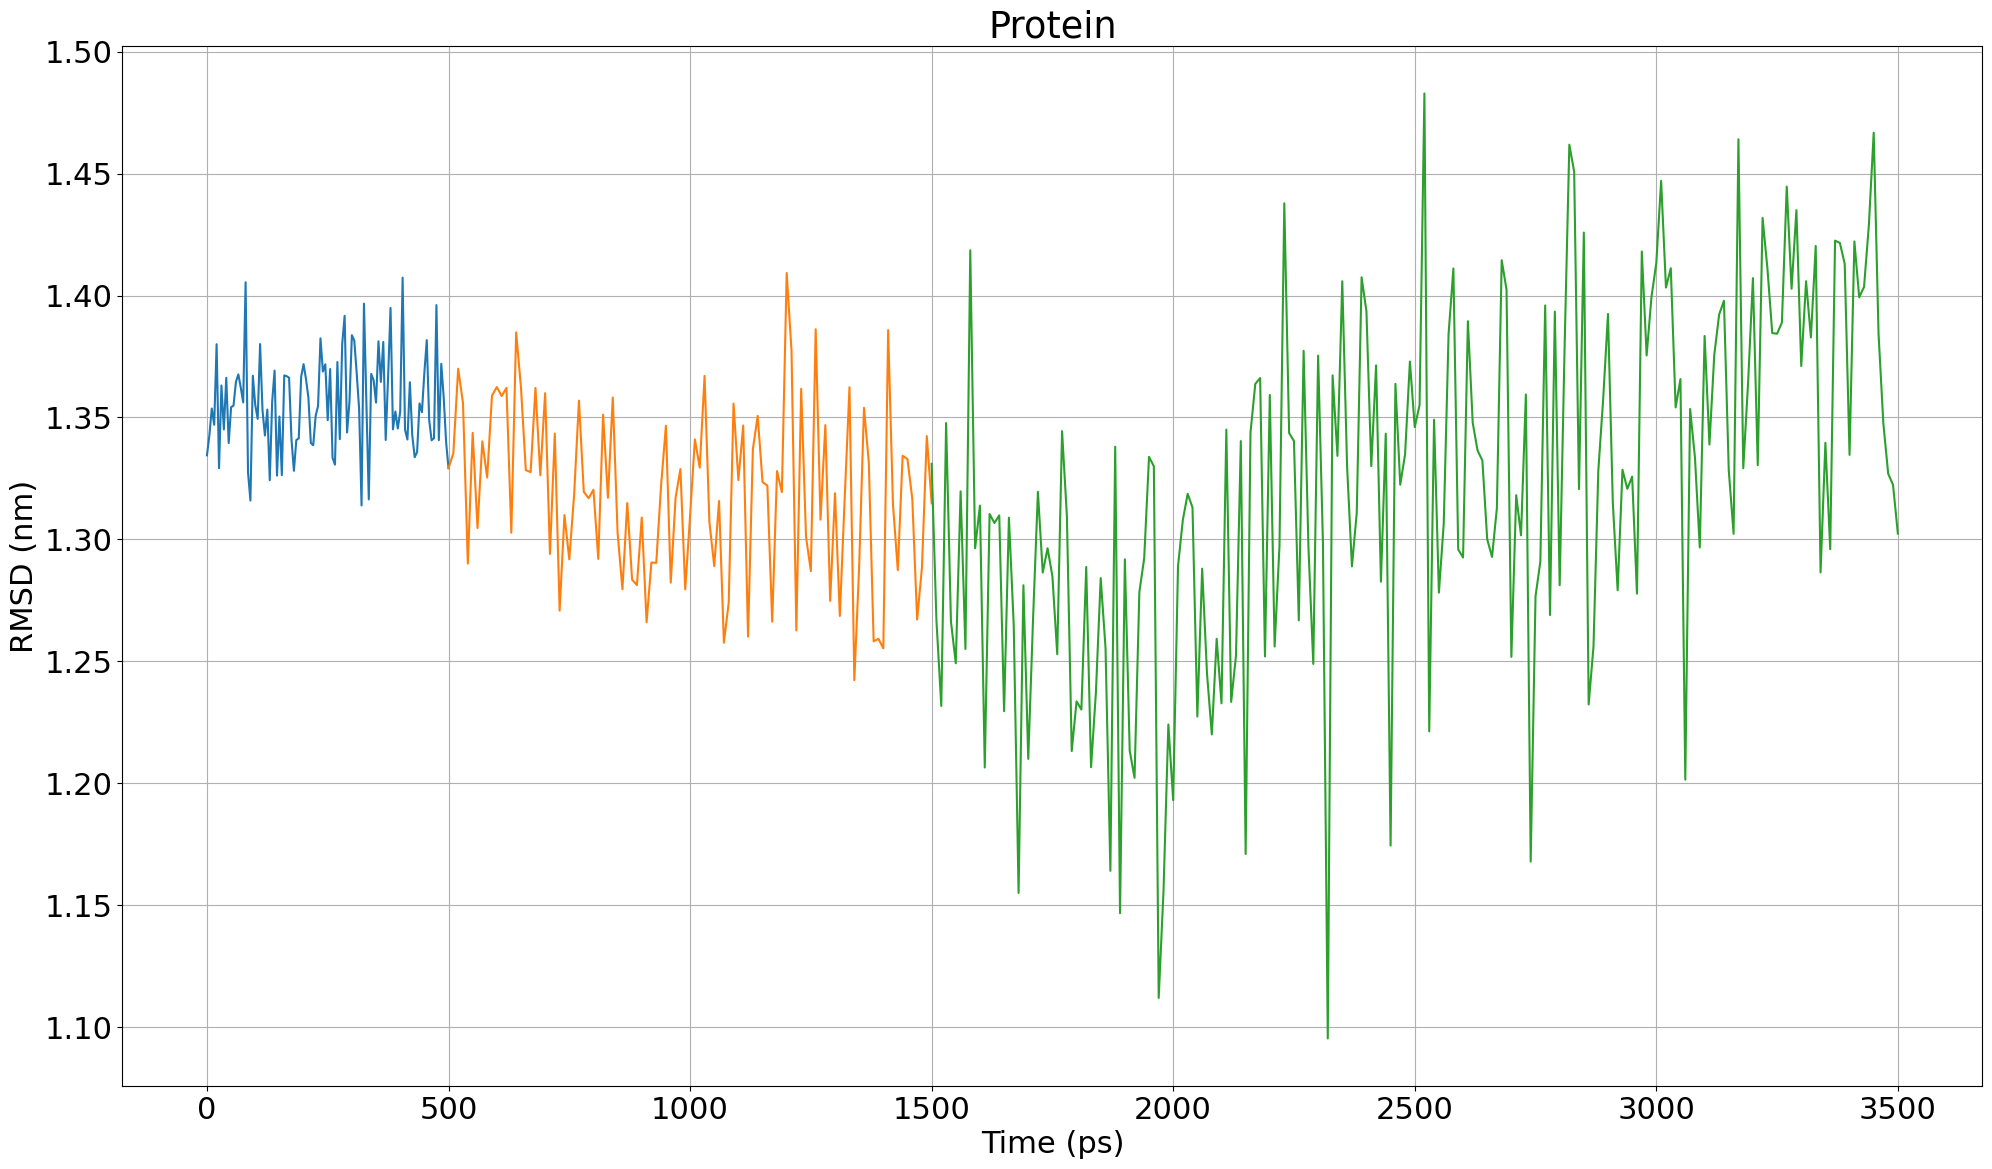

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(24,13.5))

for df in (rmsd_pd_1, rmsd_pd_2, rmsd_pd_3):
        ax.plot(df["time"], df["Protein"], label=str(df['label'][0]))
        ax.set_ylabel(quantity + "(" + unit + ")")
        
ax.set_title(struct)
ax.set_ylabel('RMSD (nm)')
ax.set_xlabel('Time (ps)')
plt.grid()

## Checkpointing
Maybe run it for a bit longer to see if the RMSD stabilizes more?

In [115]:
import pickle

with open('checkpoint.pycpt', 'wb') as py_cpt:
    pickle.dump(md_sys, py_cpt)

## Production

### TODO: 

Need to start from here.

Two ways to run this:

The `gromacs_py` state is checkpointed in created directory, in case transfer to cluster is necessary. Pickle the `md_sys` object [like this](https://www.techcoil.com/blog/how-to-save-and-load-objects-to-and-from-file-in-python-via-facilities-from-the-pickle-module/) in order to restore on kuhpc. Then, install `miniforge` and `gromacs_py` in a copy of the gromacs SIF in kuhpc.

Alternatively, get the `tpr` and `cpt` files and extend/restart from shell `gmx` in kuhpc (possibly less cumbersome), but post-processing is harder as all data needs to be re-loaded.

In [ ]:
md_sys.production(out_folder=prod_folder,
        nsteps=prod_step,
        dt=dt, vsite=vsite, maxwarn=1)


## Prepare trajectory

In [ ]:
# Center trajectory
md_sys.center_mol_box(traj=True)

## Basic Analysis

In [ ]:
rmsd_prod_pd = md_sys.get_rmsd(['C-alpha', 'Protein'], ref_sys=ref_sys)
rmsd_prod_pd['label'] = 'Production'

rmsd_prod_pd['time'] = rmsd_prod_pd['time'] + rmsd_pd['time'].max()
rmsd_all_pd = pd.concat([rmsd_pd, rmsd_prod_pd])

In [ ]:
ax = sns.lineplot(x="time", y="Protein",
        hue="label",
        data=rmsd_all_pd)
ax.set_ylabel('RMSD (nm)')
ax.set_xlabel('Time (ps)')
plt.grid()

## Trajectory vizualisation

In [ ]:
# Align the protein coordinates
md_sys.convert_trj(select='Protein\nSystem\n', fit='rot+trans', pbc='none', skip='10')

In [ ]:
view = md_sys.view_traj()
view.add_representation(repr_type='licorice', selection='protein')
view.center(selection='CA')
view